In [1]:
import os
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt

dir = "./data"
with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
    data = pandas.read_csv(f, header=0, skipinitialspace=True).values
    print(data.shape)


(8036, 7)


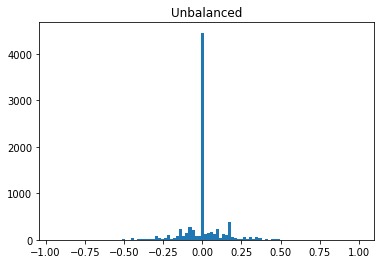

In [2]:
_ = plt.hist(data[:,3], bins=100)
plt.title('Unbalanced')
plt.show()

(2700, 7)


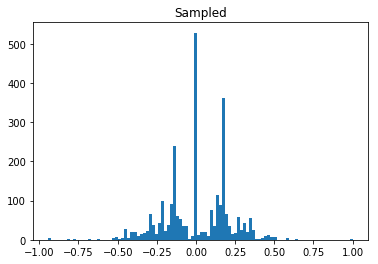

In [3]:
import random

limit = 0.1
nb_normal = 700
nb_extreme = 2000
normal = np.abs(data[:,3]) < limit
extreme = np.abs(data[:,3]) > limit
normal_choice = np.random.choice(data[normal].shape[0], nb_normal)
extreme_choice = np.random.choice(data[extreme].shape[0], nb_extreme)
normal_data = data[normal][normal_choice]
extreme_data = data[extreme][extreme_choice]
sampled_data = np.append(normal_data, extreme_data, axis=0)
print(sampled_data.shape)
_ = plt.hist(sampled_data[:,3], bins=100)
plt.title('Sampled')
plt.show()

(8100,) (8100,)


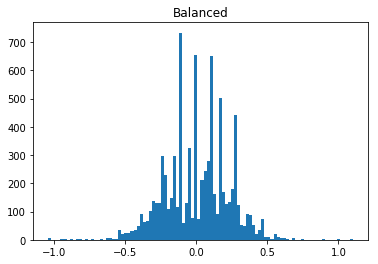

In [4]:
from sklearn.utils import shuffle

c, l, r, st, _, _, _ = np.split(sampled_data, 7, axis=1)
adj = 0.1
balanced_feats = np.append(c, l)
balanced_feats = np.append(balanced_feats, r)
balanced_labels = np.append(st, st + adj)
balanced_labels = np.append(balanced_labels, st - adj)
balanced_feats, balanced_labels = shuffle(balanced_feats, balanced_labels)
print(balanced_feats.shape, balanced_labels.shape)

_ = plt.hist(balanced_labels, bins=100)
plt.title('Balanced')
plt.show()



(8128,) (8128,)


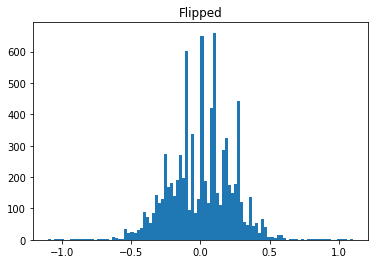

In [5]:
flip_limit = 0.75
flip = np.logical_or(balanced_labels < -flip_limit, balanced_labels > flip_limit)
flipped_feats = np.append(balanced_feats, balanced_feats[flip])
flipped_labels = np.append(balanced_labels, - balanced_labels[flip])
print(flipped_feats.shape, flipped_labels.shape)

_ = plt.hist(flipped_labels, bins=100)
plt.title('Flipped')
plt.show()


[0.030748460000000005 0.1 0.07658229999999999]


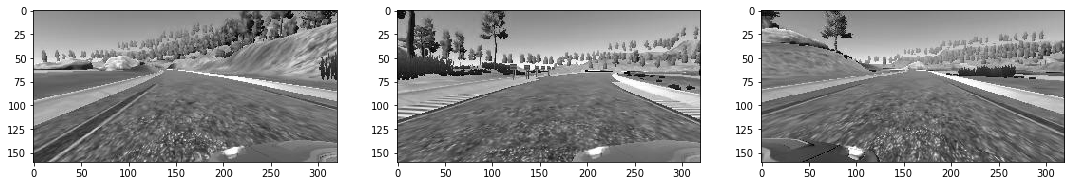

In [6]:
import cv2

features = np.array([cv2.cvtColor(
    cv2.imread(os.path.join(dir, f)), cv2.COLOR_BGR2YUV) for f in flipped_feats])
labels = flipped_labels
samples = np.random.choice(features.shape[0], 3)
f = plt.figure(figsize=(25,14))
for i in range(len(samples)): 
    s = f.add_subplot(2,4,i+1)
    s.imshow(features[samples[i]][:,:,0], cmap='gray')
print(labels[samples])
plt.show()


In [9]:
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.wrappers.scikit_learn import KerasRegressor

from keras.layers.pooling import MaxPooling2D
import numpy as np
from random import random

def my_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='c1'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 5, 5, border_mode='same', activation='relu', name='c2'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))    
    model.add(Convolution2D(128, 5, 5, border_mode='same', activation='relu', name='c3'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))    

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='d1'))
    model.add(Dense(64, activation='linear', name='d2'))
    model.add(Dense(16, activation='relu', name='d3'))
    model.add(Dense(1, activation='linear', name='out'))
    
    return model

def nvidia_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))    
    model.add(Convolution2D(24, 5, 5, border_mode='same', activation='relu', name='c1', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(36, 5, 5, border_mode='same', activation='relu', name='c2', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(48, 5, 5, border_mode='same', activation='relu', name='c3', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='c4'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='c5'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1164, name='d1'))
    model.add(Dense(100, name='d2'))
    model.add(Dense(50, name='d3'))
    model.add(Dense(10, name='d4'))
    model.add(Dense(1, name='out'))

    return model

X_train, y_train = shuffle(features, labels)
model = nvidia_model()
model.compile('adam', 'mse')
history = model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=2, validation_split=0.05)
y_pred = model.predict(X_train)

print(model.save("model.new.h5"))


Train on 7721 samples, validate on 407 samples
Epoch 1/10
45s - loss: 0.0992 - val_loss: 0.0192
Epoch 2/10
44s - loss: 0.0254 - val_loss: 0.0203
Epoch 3/10
44s - loss: 0.0225 - val_loss: 0.0163
Epoch 4/10
44s - loss: 0.0221 - val_loss: 0.0159
Epoch 5/10
44s - loss: 0.0217 - val_loss: 0.0175
Epoch 6/10
44s - loss: 0.0214 - val_loss: 0.0175
Epoch 7/10
44s - loss: 0.0208 - val_loss: 0.0180
Epoch 8/10
44s - loss: 0.0211 - val_loss: 0.0156
Epoch 9/10
44s - loss: 0.0206 - val_loss: 0.0161
Epoch 10/10
44s - loss: 0.0206 - val_loss: 0.0163


OSError: Can't prepare for writing data (File write failed: time = wed feb 15 14:16:32 2017
, filename = 'model.new.h5', file descriptor = 65, errno = 28, error message = 'no space left on device', buf = 0xad8de50, total write size = 63267744, bytes this sub-write = 63267744, bytes actually written = 18446744073709551615, offset = 224382976)

None


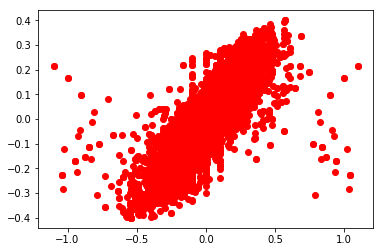

[-0.4005892] [ 0.40001854]


In [11]:
print(model.save("model.new3.h5"))

plt.plot(y_train, y_pred, 'ro')
plt.show()
print(np.min(y_pred, axis=0), np.max(y_pred, axis=0))
